# Produce Wavelets coefficients Dataset

- purpose to be used in Machine Learning

- author Sylvie Dagoret-Campagne
- creation date August 19th 2020

Decomposition up to max = 9 levels

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

import matplotlib.colors as colors
import matplotlib.cm as cmx

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [54]:
import libatmscattering as atm

In [55]:
import pywt

In [56]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = 18

In [57]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

In [58]:
def thresh_hard_sparse(x, k):
    """
    Keep only k largest entries of x and return their indices.
    Parameters
    ----------
    x : numpy array
        Numpy array to be thresholded
    k : int
        Number of largest entries in absolute value to keep
    Notes
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return ind, _x

In [59]:
def index_to_level(indexes,coeffs_shapes):
    """
    Compute the level number corresponding to the indices
    Parameters:
    ----------
    indexes : numpy array of indices
    coeffs_shape : structure of coefficients of pywt from 
    
    return the level number of each indexes (numpy array)
 
    """
    
    
    nlevels=len(coeffs_shapes)
    sum_nb_coeffs=np.zeros(nlevels)

    # first compute cumulated threshold indexes over level
    for ilevel in np.arange(nlevels):
        if ilevel==0:
            sum_nb_coeffs[ilevel]=coeffs_shapes[ilevel][0]
        else:
            sum_nb_coeffs[ilevel]=sum_nb_coeffs[ilevel-1]+coeffs_shapes[ilevel]['d'][0]
            
  
            
    # for each index compute the level
    indexes_levels=np.zeros_like(indexes)
    
    for ilevel in np.arange(nlevels):
       
        if ilevel==0:
            #indexes_levels=np.where(indexes<int(sum_nb_coeffs[ilevel]),ilevel,0)
            sel_indexes=np.where(indexes<int(sum_nb_coeffs[ilevel]))
            indexes_levels[sel_indexes[0]]=ilevel                     
        else:
            #indexes_levels=np.where(np.logical_and(indexes>=int(sum_nb_coeffs[ilevel-1]),
            #                                       indexes<=int(sum_nb_coeffs[ilevel]))
            #                                       ,ilevel,0)
            sel_indexes=np.where(
                np.logical_and(indexes>=int(sum_nb_coeffs[ilevel-1]),
                               indexes<int(sum_nb_coeffs[ilevel])))
            indexes_levels[sel_indexes[0]]=ilevel                          
                                                   
    return indexes_levels

In [60]:
DATADIR="../../data/atm"

In [61]:
atmospheric_basename_files=os.listdir(DATADIR)

In [62]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [63]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [64]:
hdu = fits.open(input_file)

In [65]:
hdr=hdu[0].header
data=hdu[0].data

In [66]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [67]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [68]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [69]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [70]:
data_header=data[1:,idx_out_num:idx_out_res]

In [71]:
NWL=wl.shape[0]

In [72]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [73]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

In [74]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [75]:
WLMINSEL=340.
WLMAXSEL=1100.

In [76]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [77]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [78]:
len(indexes_selected)

760

In [79]:
wl=wl[indexes_selected]
transm=transm[:,indexes_selected]

In [80]:
WLMIN=wl[0]
WLMAX=wl[-1]

In [81]:
# initialize wavelet
wname = "db1"
w = pywt.Wavelet(wname)

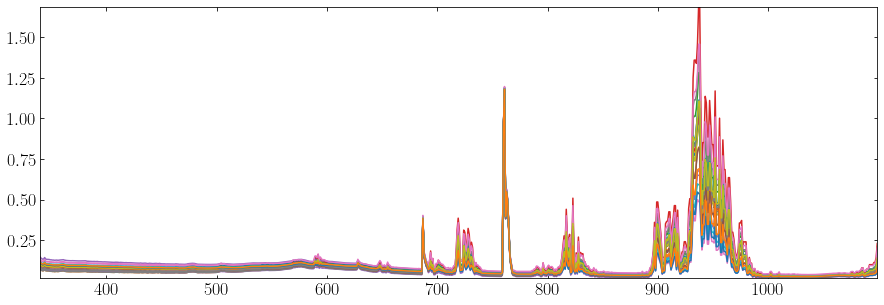

In [82]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for index_atm in np.arange(NbAtmSimul):
    #print(index_atm)
    transm0=transm[index_atm,:]
    # compute expected Rayleigh scattering
    od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
    att_rayleigh=np.exp(-od)
    
    
    # wavelet decomposition
    # correction from Rayleigh
    t=wl
    h=-2.5*np.log10(transm0/att_rayleigh)
    
    ax.plot(t,h)
    
    if index_atm>20:
        break


## Produce the list of wavelet coefficients

In [83]:
# loop on simulation

all_coeffs = []

for index_atm in np.arange(NbAtmSimul):
    #print(index_atm)
    transm0=transm[index_atm]
    # compute expected Rayleigh scattering
    od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
    att_rayleigh=np.exp(-od)
    
    
    # wavelet decomposition
    # correction from Rayleigh
    t=wl
    h=-2.5*np.log10(transm0/att_rayleigh)
    
    # max levels
    maxlvl=pywt.dwt_max_level(data_len=len(h), filter_len=w.dec_len)
    nlevels=maxlvl
    
    # wavelet decomposition
    coeffs = pywt.wavedec(h, w, level=nlevels,mode='zero')
        
    all_coeffs.append(coeffs)


In [84]:
len(all_coeffs)

3650

In [85]:
nlevels

9

In [86]:
all_datasets1=[]
all_datasets2=[]
all_datasets3=[]
all_datasets4=[]
all_datasets5=[]
all_datasets6=[]
all_datasets7=[]
all_datasets8=[]
all_datasets9=[]

for index_atm in np.arange(NbAtmSimul):

    dataset1=np.concatenate((all_coeffs[index_atm][0],all_coeffs[index_atm][1]))
    dataset2=np.concatenate((dataset1,all_coeffs[index_atm][2]))
    dataset3=np.concatenate((dataset2,all_coeffs[index_atm][3]))
    dataset4=np.concatenate((dataset3,all_coeffs[index_atm][4]))
    dataset5=np.concatenate((dataset4,all_coeffs[index_atm][5]))
    dataset6=np.concatenate((dataset5,all_coeffs[index_atm][6]))
    dataset7=np.concatenate((dataset6,all_coeffs[index_atm][7]))
    dataset8=np.concatenate((dataset7,all_coeffs[index_atm][8]))
    dataset9=np.concatenate((dataset8,all_coeffs[index_atm][9]))
       
    all_datasets1.append(dataset1)
    all_datasets2.append(dataset2)
    all_datasets3.append(dataset3)
    all_datasets4.append(dataset4)
    all_datasets5.append(dataset5)
    all_datasets6.append(dataset6)
    all_datasets7.append(dataset7)
    all_datasets8.append(dataset8)
    all_datasets9.append(dataset9)
    
    
all_datasets1=np.array(all_datasets1)
all_datasets2=np.array(all_datasets2)
all_datasets3=np.array(all_datasets3)
all_datasets4=np.array(all_datasets4)
all_datasets5=np.array(all_datasets5)
all_datasets6=np.array(all_datasets6)
all_datasets7=np.array(all_datasets7)
all_datasets8=np.array(all_datasets8)
all_datasets9=np.array(all_datasets9)

In [87]:
all_datasets1.shape

(3650, 4)

In [88]:
all_datasets9.shape

(3650, 762)

In [89]:
data_out=np.concatenate((data_header,all_datasets1),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset1.fits')
hdu_out.writeto(output_file,overwrite=True)

In [90]:
data_out=np.concatenate((data_header,all_datasets2),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset2.fits')
hdu_out.writeto(output_file,overwrite=True)

In [91]:
data_out=np.concatenate((data_header,all_datasets3),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset3.fits')
hdu_out.writeto(output_file,overwrite=True)

In [92]:
data_out=np.concatenate((data_header,all_datasets4),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset4.fits')
hdu_out.writeto(output_file,overwrite=True)

In [93]:
data_out=np.concatenate((data_header,all_datasets5),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset5.fits')
hdu_out.writeto(output_file,overwrite=True)

In [94]:
data_out=np.concatenate((data_header,all_datasets6),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset6.fits')
hdu_out.writeto(output_file,overwrite=True)

In [95]:
data_out=np.concatenate((data_header,all_datasets7),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset7.fits')
hdu_out.writeto(output_file,overwrite=True)

In [96]:
data_out=np.concatenate((data_header,all_datasets8),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset8.fits')
hdu_out.writeto(output_file,overwrite=True)

In [97]:
data_out=np.concatenate((data_header,all_datasets9),axis=1)
primary_hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu_out = fits.HDUList([primary_hdu])
output_file=os.path.join('lsst_atm_10year_wavelets_dataset9.fits')
hdu_out.writeto(output_file,overwrite=True)

In [98]:
!ls -l *.fits

-rw-r--r--  1 dagoret  staff    325440 Aug 19 20:55 lsst_atm_10year_wavelets_dataset1.fits
-rw-r--r--  1 dagoret  staff    411840 Aug 19 20:55 lsst_atm_10year_wavelets_dataset2.fits
-rw-r--r--  1 dagoret  staff    587520 Aug 19 20:55 lsst_atm_10year_wavelets_dataset3.fits
-rw-r--r--  1 dagoret  staff    938880 Aug 19 20:55 lsst_atm_10year_wavelets_dataset4.fits
-rw-r--r--  1 dagoret  staff   1638720 Aug 19 20:55 lsst_atm_10year_wavelets_dataset5.fits
-rw-r--r--  1 dagoret  staff   3041280 Aug 19 20:55 lsst_atm_10year_wavelets_dataset6.fits
-rw-r--r--  1 dagoret  staff   5814720 Aug 19 20:55 lsst_atm_10year_wavelets_dataset7.fits
-rw-r--r--  1 dagoret  staff  11364480 Aug 19 20:55 lsst_atm_10year_wavelets_dataset8.fits
-rw-r--r--  1 dagoret  staff  22458240 Aug 19 20:55 lsst_atm_10year_wavelets_dataset9.fits
